In [3]:
import json
import pandas as pd
import torch
from datasets import load_dataset


CONFIG = {
    "base": "Qwen/Qwen2.5-1.5B-Instruct", # base model
    "device": torch.device("cuda"),

    # model names and prices
    "model_keys": {
        'gpt-5-nano-2025-08-07_response': (0.05, 0.40),
        'grok-4-fast-reasoning_response': (0.20, 0.50),
        'openai_gpt-oss-120b_response': (0.05, 0.24),
        'openai_gpt-oss-20b_response': (0.03, 0.14),
        'nvidia_NVIDIA-Nemotron-Nano-9B-v2_response': (0.04, 0.16),
        'meta-llama_Llama-3.2-11B-Vision-Instruct_response': (0.049, 0.049),
        'moonshotai_Kimi-K2-Instruct-0905_response': (0.50, 2.00),
        'gemini-2.5-flash-lite_response': (0.10, 0.40),
    },

    "PEAK_LR": 1e-6,
    "BATCH_SIZE": 16,
    "EPOCHS": 8,
    "WEIGHT_DECAY": 0.04,
    "NUM_WARMUP_STEPS": 50,
    "SAVE_PATH": "models/router_qwen2.5"
}

def load_data(dataset, model_name, length=None):
    ds = load_dataset(dataset, split="train")
    df = ds.to_pandas()
    if length is not None:
        df = df.head(length)


    # Split into train and validation
    df_train = df.sample(frac=0.9, random_state=42)
    df_val = df.drop(df_train.index).reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)

    return df_train, df_val

df_train, df_val = load_data("a5ilank/RouterBench2.0", "gemini-2.5-flash-lite_response")
# Keep question and all model columns
model_cols = list(CONFIG["model_keys"].keys())
df_train = df_train[['question'] + model_cols]
df_val = df_val[['question'] + model_cols]

# Calculate stats for all models
for model_key in CONFIG["model_keys"].keys():
    num_pos = sum(df_train[model_key].apply(lambda d: d['is_correct'] if isinstance(d, dict) else False))
    num_neg = len(df_train) - num_pos
    print(f"\n{model_key}:")
    print(f"  Number of positive samples: {num_pos}")
    print(f"  Number of negative samples: {num_neg}")


gpt-5-nano-2025-08-07_response:
  Number of positive samples: 14345
  Number of negative samples: 2293

grok-4-fast-reasoning_response:
  Number of positive samples: 15190
  Number of negative samples: 1448

openai_gpt-oss-120b_response:
  Number of positive samples: 13454
  Number of negative samples: 3184

openai_gpt-oss-20b_response:
  Number of positive samples: 13405
  Number of negative samples: 3233

nvidia_NVIDIA-Nemotron-Nano-9B-v2_response:
  Number of positive samples: 14034
  Number of negative samples: 2604

meta-llama_Llama-3.2-11B-Vision-Instruct_response:
  Number of positive samples: 9719
  Number of negative samples: 6919

moonshotai_Kimi-K2-Instruct-0905_response:
  Number of positive samples: 13019
  Number of negative samples: 3619

gemini-2.5-flash-lite_response:
  Number of positive samples: 13096
  Number of negative samples: 3542


In [5]:
# Count oracle performance (how many questions have no correct model)
oracle_total = len(df_train)
oracle_all_wrong = 0

for _, row in df_train.iterrows():
    # Extract all is_correct flags for this row
    correct_flags = []
    for model_key in model_cols:
        entry = row[model_key]
        if isinstance(entry, dict):
            correct_flags.append(entry.get("is_correct", False))
        else:
            correct_flags.append(False)
    
    # If no model was correct for this question
    if not any(correct_flags):
        oracle_all_wrong += 1

print("\n=== Oracle Statistics ===")
print(f"Total samples: {oracle_total}")
print(f"Samples where ALL models are wrong: {oracle_all_wrong}")
print(f"Oracle accuracy upper bound: {(oracle_total - oracle_all_wrong) / oracle_total:.4f}")



=== Oracle Statistics ===
Total samples: 16638
Samples where ALL models are wrong: 498
Oracle accuracy upper bound: 0.9701


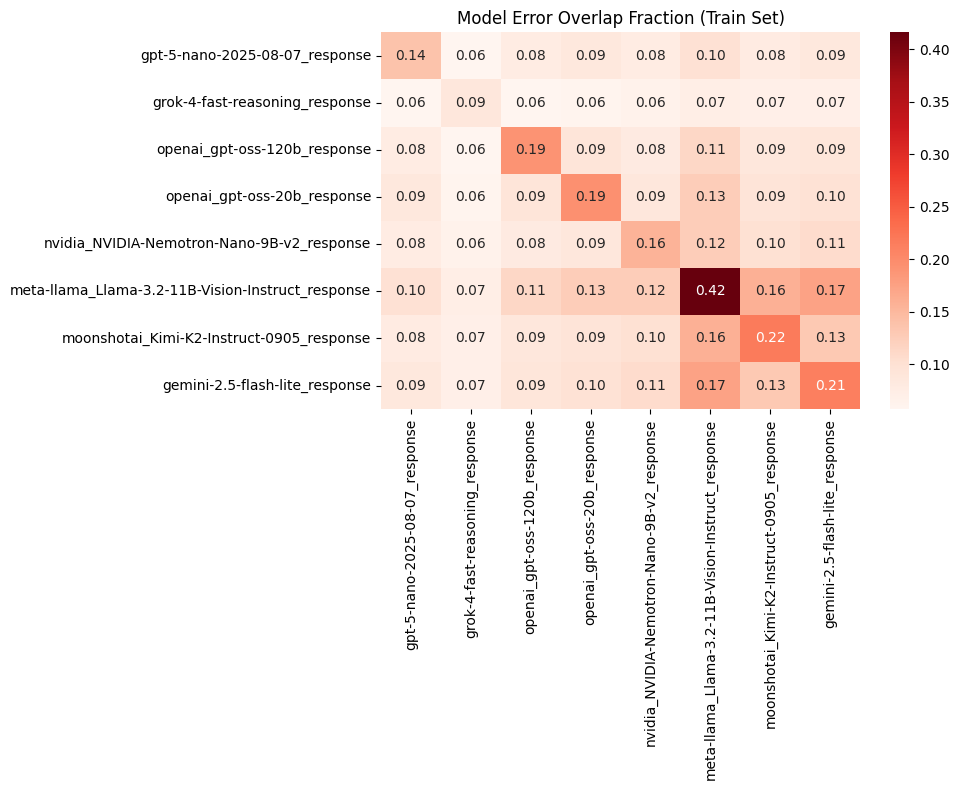

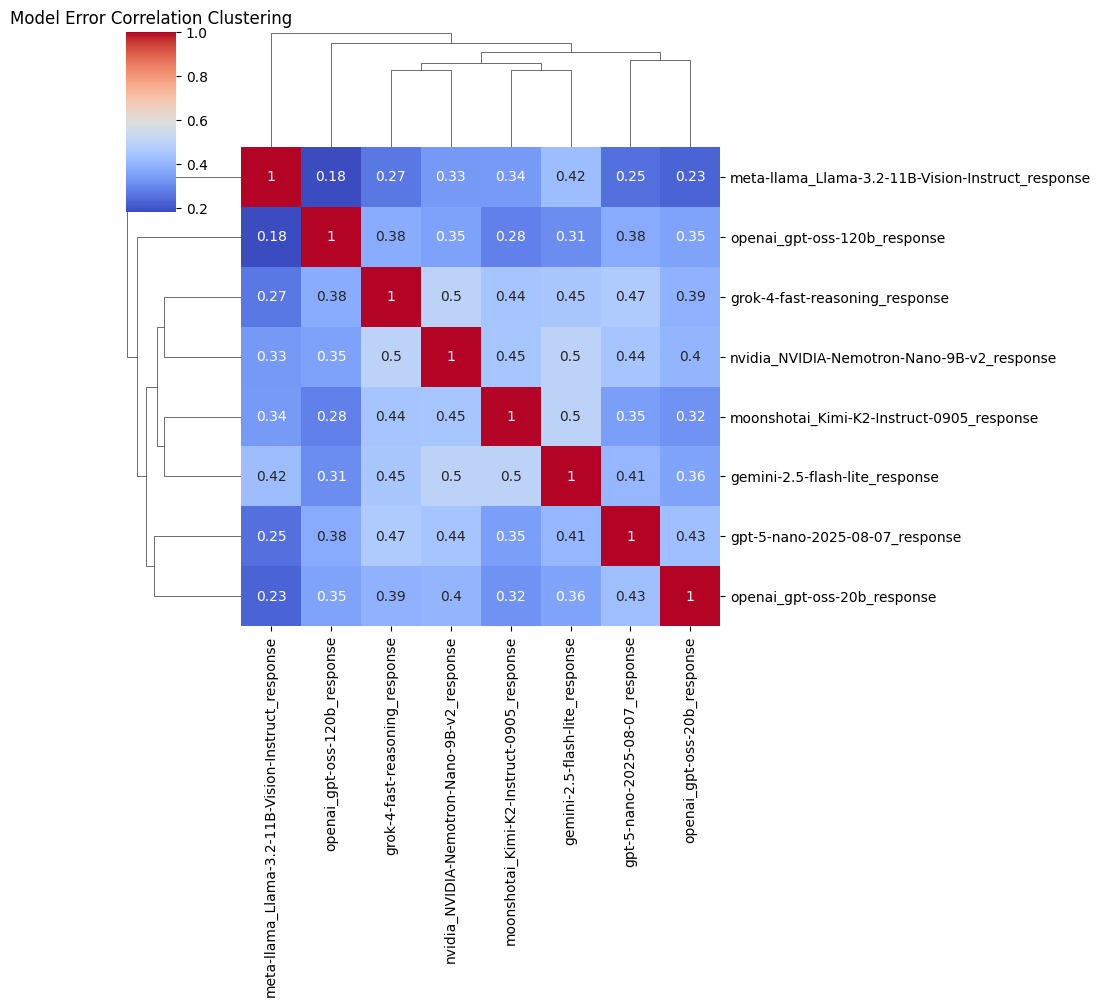

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Build error matrix ---
error_matrix = pd.DataFrame()

for model_key in CONFIG["model_keys"].keys():
    # True if incorrect
    error_matrix[model_key] = df_train[model_key].apply(
        lambda d: not d['is_correct'] if isinstance(d, dict) else False
    )

# --- Compute pairwise mistake overlaps ---
overlap_matrix = pd.DataFrame(index=model_cols, columns=model_cols, dtype=float)

for m1 in model_cols:
    for m2 in model_cols:
        # % of questions where BOTH models were wrong
        both_wrong = ((error_matrix[m1]) & (error_matrix[m2])).sum()
        overlap_matrix.loc[m1, m2] = both_wrong

# --- Normalize by total dataset size for percentages ---
overlap_matrix = overlap_matrix / len(df_train)

# ============================
# Plot 1 — Heatmap of overlaps
# ============================
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, cmap="Reds", fmt=".2f")
plt.title("Model Error Overlap Fraction (Train Set)")
plt.tight_layout()
plt.show()

# ==============================
# Plot 2 — Clustermap of errors
# ==============================
sns.clustermap(error_matrix.corr(), cmap="coolwarm", annot=True, figsize=(10, 10))
plt.title("Model Error Correlation Clustering")
plt.show()
